# Toy 03: measuring relative position

HOWTO: run the dataset & model cells, then run either of the solution cells following by the analysis cell.

In [2]:
%load_ext autoreload

### Dataset

In [4]:
%autoreload
import datasets

images, labels, n_classes = datasets.dataset_relative_position()
train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels = datasets.split_dataset(images, labels)

35 training samples
35 test samples
35 analysis samples


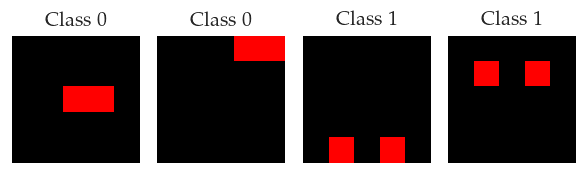

In [5]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

fig, axs = plt.subplots(1, 4, figsize=(1 + 2 * 2, 2), dpi=120)
j = 0
for c in range(2):
    for i in range(2):
        inds = train_labels == c
        axs[j].imshow(train_images[inds][i].permute((1, 2, 0)))
        axs[j].set_title(f"Class {train_labels[inds][i]}")
        axs[j].axis('off')
        j += 1

plt.tight_layout()
pass

## Model

In [6]:
%autoreload
from toy_models import TriViTalAbsolutePosition

# %autoreload

# from torch import nn
# import ml_collections

# import sys
# sys.path.append('..')

# from models.vit_modeling import Block
# from models.pos_embeddings import get_raw_coordinate
# from models.learnable_sinusoid import LearnableSinusoidPositionalEncoding

# def block_config(d=4, mlp_d=None, n_heads=1):
#     config = ml_collections.ConfigDict()
#     config.patches = ml_collections.ConfigDict({'size': (1, 1)})
#     config.hidden_size = d
#     config.transformer = ml_collections.ConfigDict()
#     config.transformer.mlp_dim = mlp_d if mlp_d is not None else d
#     config.transformer.num_heads = n_heads
#     config.transformer.num_layers = 1
#     config.transformer.attention_dropout_rate = 0.0
#     config.transformer.dropout_rate = 0.0
#     return config

# class TriViTal(nn.Module):
#     def __init__(self, handcrafted_weights=None, n_classes=2, d=4, n_heads=1, rel_pos_shared_heads=True, track_pos=True, pos_emb='absolute', softmax=True, use_rel_pos=True):
#         super().__init__()
#         self.patch_layer = nn.Conv2d(3, d, kernel_size=1, padding=0)

#         self.pos_emb = pos_emb
#         if self.pos_emb == 'absolute':
#             self.pos_embedding = nn.Parameter(torch.randn(1, d, 5, 5) * 0.1)
#         elif self.pos_emb == 'sinusoid_learnable_new':
#             self.pos = nn.Parameter(get_raw_coordinate(5 * 5), requires_grad=False)
#             self.sin_model = LearnableSinusoidPositionalEncoding(2, d // 2, d, 4 * d, initialize='sinusoid')
#             self.pos_embedding = None
#         elif self.pos_emb == 'none':
#             self.pos_embedding = None
#         else:
#             raise NotImplementedError(f"Unknown pos_emb: {pos_emb}")

#         # self.block1 = Block(block_config(d), True, None, False, False, override_attn_out_dim=2)
#         self.block1 = Block(block_config(d, n_heads=n_heads), use_rel_pos=use_rel_pos, softmax=softmax, rel_pos_heads=None if rel_pos_shared_heads else n_heads, img_size=(5, 5), norm=False, residual=False)
#         # self.block1 = Block(block_config(d, n_heads=n_heads), use_rel_pos=True, img_size=(5, 5), norm=False, residual=False)
#         # self.pool = nn.AdaptiveAvgPool1d([1])
#         self.pool = nn.AdaptiveMaxPool1d([1])
#         self.flatten = nn.Flatten()
#         self.fc = nn.Linear(d, n_classes)

#         self.track_pos = track_pos

#         self.attn_weights = None
#         self.patch_activations = None
#         self.token_activations = None
#         self.attn_activations = None

#         if handcrafted_weights is not None:
#             params = dict(self.named_parameters())
#             training = {n: True for n in params.keys()}
#             for name, param in handcrafted_weights.items():
#                 params[name].data = handcrafted_weights[name]
#                 training[name] = False
#                 params[name].retain_grad()

#             # print('\nTraining:')
#             # for name in training:
#             #     print(f"{name}: {training[name]}")

#             if all([not training[name] for name in params]):
#                 print('\nNo parameters to train!')

#     def forward(self, x):
#         self.image_in = x
#         self.image_in.requires_grad = True
#         self.image_in.retain_grad()

#         def to_attn_format(data):
#             return data.permute((0, 2, 3, 1)).view(data.shape[0], -1, data.shape[1])
#         def from_attn_format(data):
#             return data.permute([0, 2, 1])
#         def from_attn_format_2d(data):
#             return data.permute([0, 2, 1]).view(data.shape[0], -1, 5, 5)

#         # Learnable sinusoid
#         if self.pos_emb == 'sinusoid_learnable_new':
#             self.pos_embedding = from_attn_format_2d(self.sin_model(self.pos))
#             # self.pos_embedding.requires_grad = True
#             self.pos_embedding.retain_grad()

#         out_sem = self.patch_layer(x)
#         self.patch_activations = out_sem

#         if self.pos_emb == 'none':
#             self.pos_embedding = torch.zeros_like(out_sem)

#         out_pos = self.pos_embedding
#         self.pos_emb_in = out_pos
#         out = out_sem + out_pos
#         self.token_activations = out

#         out = to_attn_format(out)
#         out, self.attn_probs, self.attn_probs_sliced = self.block1(out)

#         # To make feature maps differentiable *per sample* we
#         # need to include the slicing per sample in the graph. Otherwise
#         # autograd.grad() complains that the sliced tensors are not in the
#         # graph when we later compute the image/position attributions wrt
#         # the feature map.
#         self.attn_out_sliced = []
#         # Shape of feature map: [batch_size, tokens, channels]
#         B, D, C = out.shape
#         for i in range(B):
#             # What we want: first dimension should be [num_heads], so
#             # autograd.grad() can compute the "batched" vector-Jacobian for each
#             # head, as we will use the "batched" mode of grad() where the first
#             # dimension needs to contain the "batches".
#             num_heads = self.block1.attn.num_attention_heads
#             grad_compat_slice = out[i].permute((1, 0)).reshape(num_heads, -1, D)
#             grad_compat_slice.retain_grad()
#             self.attn_out_sliced.append(grad_compat_slice)
#         out = torch.stack(self.attn_out_sliced).reshape(B, C, D).permute((0, 2, 1))

#         out = from_attn_format(out)

#         self.attn_activations = out

#         out = self.pool(out)
#         out = self.flatten(out)
#         out = self.fc(out)

#         return out

# # seed = 5
# # pos_emb = 'sinusoid_learnable_new'
# # d = 16
# # n_heads = 4

# seed = 0
# pos_emb = 'none'
# d = 16
# n_heads = 4

/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../models/irpe.py:14: UserWarning: [WARNING] The module `rpe_ops` is not built. For better training performance, please build `rpe_ops`.
  warnings.warn(RED_STR.format("[WARNING] The module `rpe_ops` is not built. \


# Handcrafted solution

In [7]:
%autoreload

import training
from utils import toy_analysis

# Handcrafted weights
rpe_w_l0 = torch.tensor([[0.], [0.], [0.], [1.], [0.], [0.], [0.], [0.], [0.]])
rpe_w_l1 = torch.tensor([[0.], [0.], [1.], [0.], [0.], [0.], [0.], [0.], [0.]])
rpe_w = torch.stack([rpe_w_l0] * 5 + [rpe_w_l1] * 5)
rpe_h = torch.zeros((10, 9, 1), dtype=torch.float32)
handcrafted_weights = {
    'patch_layer.weight': torch.tensor([[[[1.]], [[0.]], [[0.]]]]),
    'patch_layer.bias': torch.tensor([0.]),
    # 'pos_embedding': torch.zeros((1, 2, 5, 5)),
    'block1.attn.query.weight': torch.tensor([[1.], [1.]]),
    'block1.attn.query.bias': torch.tensor([0., 0.]),
    'block1.attn.key.weight': torch.tensor([[0.], [0.]]),
    'block1.attn.key.bias': torch.tensor([0., 0.]),
    'block1.attn.value.weight': torch.tensor([[1.], [1.]]),
    'block1.attn.value.bias': torch.tensor([0., 0.]),
    'block1.attn.out.weight': torch.diag(torch.tensor([1., 1.])),
    'block1.attn.out.bias': torch.tensor([0., 0.]),
    'block1.ffn.fc1.weight': torch.diag(torch.tensor([1., 1.])),
    'block1.ffn.fc1.bias': torch.tensor([0., 0.]),
    'block1.ffn.fc2.weight': torch.diag(torch.tensor([1., 1.])),
    'block1.ffn.fc2.bias': torch.tensor([0., 0.]),
    'block1.attn.rel_pos.emb_w.rel_pos_emb': rpe_w,
    'block1.attn.rel_pos.emb_h.rel_pos_emb': rpe_h,
    'fc.weight': torch.tensor([[1., 0.], [0., 1.]]),
    'fc.bias': torch.tensor([0., 0.]),
}
model = TriViTal(d=2, n_classes=n_classes, handcrafted_weights=handcrafted_weights, n_heads=2, rel_pos_shared_heads=False, pos_emb='none', softmax=True)
training.test_toy(model, test_images, test_labels)

# Analysis
seed = 0
n_samples = None
targets = ['pred_class']
shape = 'scalar'
# targets = ['attn_out_sliced']
# shape = 'head'
patch_size = 1
exclude_bias = True

toy_analysis(targets, shape, patch_size, seed, n_samples, model, test_images, test_labels, exclude_bias=exclude_bias)


No parameters to train!
Accuracy: 1.0


{'appearance': tensor(0.8025), 'relative_position': tensor(0.1975)}

# Training solution

In [9]:
%autoreload

import torch
import numpy as np

import training
import utils
from utils import toy_analysis

def run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=250, attribution_method='input_gradient_withnegative', weight_decay=0., aggregate_fn='sum'):
    biases = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
    biases_withbias = {'bias': [], 'appearance': [], 'position': [], 'relative_position': []}
    cls_biases = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
    cls_biases_withbias = {c: {'bias': [], 'appearance': [], 'position': [], 'relative_position': []} for c in range(n_classes)}
    for seed in seeds:
        torch.manual_seed(seed)
        model = TriViTalAbsolutePosition(n_classes=n_classes, d=d, n_heads=n_heads, use_rel_pos=use_rel_pos, pos_emb=pos_emb, size=5)
        training.train_toy(model, train_images, train_labels, test_images, test_labels, epochs=n_epochs, report_every_n=report_every_n, batch_size=128, lr=lr, weight_decay=weight_decay)

        sources_available = ['image', 'bias']
        if pos_emb != 'none':
            sources_available.append('pos_emb')
        if use_rel_pos:
            sources_available.append('relpos')
        seed_biases, seed_biases_withbias, seed_cls_biases, seed_cls_biases_withbias = \
            utils.toy_all_analyses(model, analysis_images, analysis_labels, n_classes, seed, sources_available=sources_available, attribution_method=attribution_method, aggregate_fn=aggregate_fn)

        for key in seed_biases:
            biases[key].append(seed_biases[key])
            for c in range(n_classes):
                cls_biases[c][key].append(seed_cls_biases[c][key])

        for key in seed_biases_withbias:
            biases_withbias[key].append(seed_biases_withbias[key])
            for c in range(n_classes):
                cls_biases_withbias[c][key].append(seed_cls_biases_withbias[c][key])

    utils.toy_postprocess_analysis(biases, biases_withbias, cls_biases, cls_biases_withbias, seeds, n_classes, sort_by_appearance=True)
    return model

### Full results from tuning

In [26]:
import pandas as pd
from io import StringIO

results = """
index,mean_acc,mean_appearance,std_appearance,mean_position,std_position,mean_relative_position,std_relative_position,lr,pos_emb_factor,weight_decay,position_mix,pe
0,0.9571428298950195,0.3365404009819031,0.16775935888290405,0.6634595990180969,0.16775937378406525,0,0,0.004,0.1,0.0,6/0,APE
1,0.9928571581840515,0.3380359411239624,0.19212014973163605,0.6619641184806824,0.19212014973163605,0,0,0.004,0.1,1e-08,6/0,APE
2,0.9357142448425293,0.3177730143070221,0.1960112303495407,0.6822269558906555,0.19601121544837952,0,0,0.004,0.1,1e-07,6/0,APE
3,0.9357142448425293,0.3011438846588135,0.15822051465511322,0.6988561153411865,0.15822049975395203,0,0,0.004,0.1,1e-06,6/0,APE
4,1.0,0.3675810694694519,0.1537342667579651,0.6324188709259033,0.1537342518568039,0,0,0.004,0.1,1e-05,6/0,APE
5,0.954285740852356,0.22527828812599182,0.18279655277729034,0.7747217416763306,0.18279656767845154,0,0,0.004,0.1,0.0001,6/0,APE
6,0.8714286088943481,0.22244444489479065,0.21792510151863098,0.7775555849075317,0.21792510151863098,0,0,0.004,0.1,0.001,6/0,APE
7,0.5914286375045776,0.15400445461273193,0.09907274693250656,0.8459954261779785,0.09907273948192596,0,0,0.004,0.1,0.01,6/0,APE
8,0.571428656578064,0.14013658463954926,0.1651206761598587,0.8598634004592896,0.1651206761598587,0,0,0.004,0.1,0.1,6/0,APE
9,0.9714285731315613,0.3325501084327698,0.1397329419851303,0.667449951171875,0.1397329419851303,0,0,0.04,0.1,0.0,6/0,APE
10,0.9757143259048462,0.3035869896411896,0.12416642904281616,0.696412980556488,0.12416645139455795,0,0,0.04,0.1,1e-08,6/0,APE
11,0.9871428608894348,0.3182969093322754,0.12710987031459808,0.6817031502723694,0.1271098554134369,0,0,0.04,0.1,1e-07,6/0,APE
12,0.949999988079071,0.30476921796798706,0.11301570385694504,0.6952308416366577,0.11301570385694504,0,0,0.04,0.1,1e-06,6/0,APE
13,0.9785714149475098,0.2840064465999603,0.11979037523269653,0.7159935832023621,0.11979038268327713,0,0,0.04,0.1,1e-05,6/0,APE
14,0.9714285731315613,0.33920449018478394,0.17615734040737152,0.6607955098152161,0.17615734040737152,0,0,0.04,0.1,0.0001,6/0,APE
15,0.6500000357627869,0.21365472674369812,0.13634195923805237,0.7863453030586243,0.13634195923805237,0,0,0.04,0.1,0.001,6/0,APE
16,0.571428656578064,0.09525144845247269,0.06404411792755127,0.6047486066818237,0.39617010951042175,0,0,0.04,0.1,0.01,6/0,APE
17,0.571428656578064,6.303886266323389e-07,9.523765243102389e-07,0.5499993562698364,0.4974931478500366,0,0,0.04,0.1,0.1,6/0,APE
0,1.0,0.4464631676673889,0.2847873568534851,0.0,0.0,0.5535367727279663,0.2847873866558075,0.004,0.1,0.0,6/0,RPE
1,1.0,0.43684855103492737,0.2888234257698059,0.0,0.0,0.563151478767395,0.2888234257698059,0.004,0.1,1e-08,6/0,RPE
2,1.0,0.4195384383201599,0.2801244258880615,0.0,0.0,0.5804616212844849,0.2801244258880615,0.004,0.1,1e-07,6/0,RPE
3,1.0,0.4743484556674957,0.3093966841697693,0.0,0.0,0.5256515741348267,0.3093966841697693,0.004,0.1,1e-06,6/0,RPE
4,1.0,0.44894084334373474,0.2777906358242035,0.0,0.0,0.5510591268539429,0.2777906358242035,0.004,0.1,1e-05,6/0,RPE
5,0.9571428298950195,0.44788655638694763,0.29629915952682495,0.0,0.0,0.55211341381073,0.29629915952682495,0.004,0.1,0.0001,6/0,RPE
6,0.6571428775787354,0.8252596855163574,0.354755699634552,0.0,0.0,0.17474031448364258,0.354755699634552,0.004,0.1,0.001,6/0,RPE
7,0.571428656578064,1.0,0.0,0.0,0.0,2.902121489239425e-17,1.2646827912794284e-16,0.004,0.1,0.01,6/0,RPE
8,0.571428656578064,1.0,0.0,0.0,0.0,0.0,0.0,0.004,0.1,0.1,6/0,RPE
9,1.0,0.5613295435905457,0.322354257106781,0.0,0.0,0.43867045640945435,0.3223542273044586,0.04,0.1,0.0,6/0,RPE
10,1.0,0.5292537212371826,0.2989211976528168,0.0,0.0,0.4707462787628174,0.2989211976528168,0.04,0.1,1e-08,6/0,RPE
11,1.0,0.5920625925064087,0.31485864520072937,0.0,0.0,0.40793734788894653,0.31485864520072937,0.04,0.1,1e-07,6/0,RPE
12,1.0,0.4106876254081726,0.25588154792785645,0.0,0.0,0.5893123149871826,0.25588151812553406,0.04,0.1,1e-06,6/0,RPE
13,1.0,0.4234231114387512,0.16916272044181824,0.0,0.0,0.5765768885612488,0.16916272044181824,0.04,0.1,1e-05,6/0,RPE
14,0.8071428537368774,0.6617239713668823,0.34630900621414185,0.0,0.0,0.33827608823776245,0.34630900621414185,0.04,0.1,0.0001,6/0,RPE
15,0.5928572416305542,0.9536913633346558,0.20185454189777374,0.0,0.0,0.04630860313773155,0.20185454189777374,0.04,0.1,0.001,6/0,RPE
16,0.571428656578064,0.6499999761581421,0.4769695997238159,0.0,0.0,0.0,0.0,0.04,0.1,0.01,6/0,RPE
17,0.571428656578064,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.1,0.1,6/0,RPE
0,1.0,0.25518718361854553,0.11675310134887695,0.39105379581451416,0.13843007385730743,0.3537590503692627,0.1252717673778534,0.004,0.1,0.0,6/0,APE+RPE
1,1.0,0.25434428453445435,0.11548248678445816,0.37658655643463135,0.12465532124042511,0.3690691590309143,0.13244138658046722,0.004,0.1,1e-08,6/0,APE+RPE
2,1.0,0.2507510185241699,0.1192658394575119,0.38775596022605896,0.1371876299381256,0.3614930212497711,0.13106977939605713,0.004,0.1,1e-07,6/0,APE+RPE
3,1.0,0.2583909034729004,0.13035087287425995,0.39120417833328247,0.12181301414966583,0.35040488839149475,0.13234634697437286,0.004,0.1,1e-06,6/0,APE+RPE
4,1.0,0.25803184509277344,0.13786067068576813,0.3985002040863037,0.13075383007526398,0.34346792101860046,0.1304033398628235,0.004,0.1,1e-05,6/0,APE+RPE
5,1.0,0.2179480493068695,0.14977020025253296,0.4426155984401703,0.18000271916389465,0.3394363820552826,0.15290498733520508,0.004,0.1,0.0001,6/0,APE+RPE
6,0.9714285731315613,0.31365329027175903,0.2209610939025879,0.4859623908996582,0.2191866785287857,0.20038433372974396,0.16637784242630005,0.004,0.1,0.001,6/0,APE+RPE
7,0.6142857670783997,0.1645447015762329,0.0673735961318016,0.8311080932617188,0.07453089952468872,0.004347196314483881,0.01817636750638485,0.004,0.1,0.01,6/0,APE+RPE
8,0.571428656578064,0.15450531244277954,0.20499487221240997,0.8454946279525757,0.20499487221240997,0.0,0.0,0.004,0.1,0.1,6/0,APE+RPE
9,1.0,0.2660435736179352,0.10558552294969559,0.4438411295413971,0.08152370154857635,0.2901152968406677,0.12185323983430862,0.04,0.1,0.0,6/0,APE+RPE
10,1.0,0.25998902320861816,0.09567669779062271,0.4390280246734619,0.10809142142534256,0.3009829819202423,0.12868474423885345,0.04,0.1,1e-08,6/0,APE+RPE
11,1.0,0.3113827109336853,0.10257880389690399,0.44401025772094727,0.08451575040817261,0.24460697174072266,0.11604730039834976,0.04,0.1,1e-07,6/0,APE+RPE
12,1.0,0.29579323530197144,0.12126372754573822,0.41762590408325195,0.09404940158128738,0.286580890417099,0.11003883928060532,0.04,0.1,1e-06,6/0,APE+RPE
13,1.0,0.23050031065940857,0.11544710397720337,0.4061073660850525,0.14664672315120697,0.36339232325553894,0.11345208436250687,0.04,0.1,1e-05,6/0,APE+RPE
14,1.0,0.20456469058990479,0.15179188549518585,0.4060516357421875,0.21893516182899475,0.3893836438655853,0.2200639396905899,0.04,0.1,0.0001,6/0,APE+RPE
15,0.7000000476837158,0.18606218695640564,0.13563276827335358,0.6978951692581177,0.30249232053756714,0.11604263633489609,0.20701313018798828,0.04,0.1,0.001,6/0,APE+RPE
16,0.571428656578064,0.11269688606262207,0.05038056895136833,0.7373031377792358,0.3102082312107086,0.0,0.0,0.04,0.1,0.01,6/0,APE+RPE
17,0.571428656578064,0.012255522422492504,0.05340966209769249,0.5377444624900818,0.4892061650753021,0.0,0.0,0.04,0.1,0.1,6/0,APE+RPE
"""

df = pd.read_csv(StringIO(results), sep=",")

# Remove rows where mean_acc is below 1.0
df = df[df['mean_acc'] == 1.0]
df = df.drop(columns=['mean_acc'])

df['mean_total_position'] = df['mean_position'] + df['mean_relative_position']
df['std_total_position'] = df['std_position'] + df['std_relative_position']
df = df.drop(columns=['mean_position', 'std_position', 'mean_relative_position', 'std_relative_position'])

# Remove column
df = df.drop(columns=['index', 'position_mix', 'pos_emb_factor'])

# Set Pandas to display all rows
pd.set_option('display.max_rows', None)

df

,mean_appearance,std_appearance,lr,weight_decay,pe,mean_total_position,std_total_position
4,0.367581,0.153734,0.004,1.000000e-05,APE,0.632419,0.153734
18,0.446463,0.284787,0.004,0.000000e+00,RPE,0.553537,0.284787
19,0.436849,0.288823,0.004,1.000000e-08,RPE,0.563151,0.288823
20,0.419538,0.280124,0.004,1.000000e-07,RPE,0.580462,0.280124
21,0.474348,0.309397,0.004,1.000000e-06,RPE,0.525652,0.309397
22,0.448941,0.277791,0.004,1.000000e-05,RPE,0.551059,0.277791
27,0.561330,0.322354,0.040,0.000000e+00,RPE,0.438670,0.322354
28,0.529254,0.298921,0.040,1.000000e-08,RPE,0.470746,0.298921
29,0.592063,0.314859,0.040,1.000000e-07,RPE,0.407937,0.314859
30,0.410688,0.255882,0.040,1.000000e-06,RPE,0.589312,0.255882


/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Toy \\#3: Relative position - AP+RP sensitivity'}, xlabel='Weight decay', ylabel='AP+RP sensitivity (mean over 20 seeds)'>

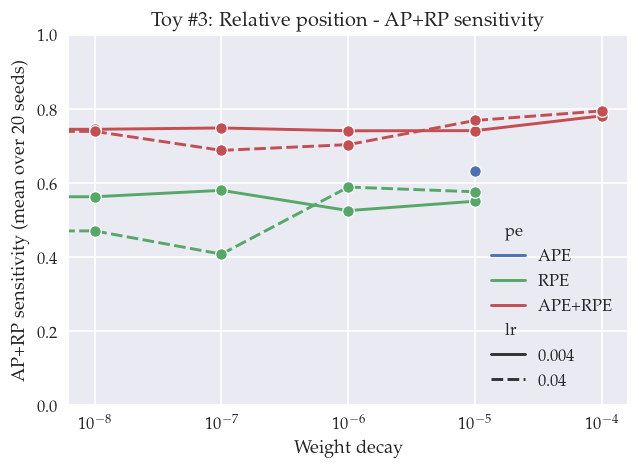

In [34]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn'])
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Palatino"]})
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

plot_df = df.copy()
# plot_df = plot_df[plot_df['lr'] == 4e-3]

# Plot lines: x = weight_decay, y = mean_total_position, for each ape + rpe combination, including std_total_position
fig, axs = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
axs.set_xscale('log')
axs.set_ylim([0, 1])
axs.set_xlabel('Weight decay')
axs.set_ylabel('AP+RP sensitivity (mean over 20 seeds)')
axs.set_title('Toy \#3: Relative position - AP+RP sensitivity')
sns.lineplot(data=plot_df, x='weight_decay', y='mean_total_position', hue='pe', style='lr', ax=axs, marker='o')

<ErrorbarContainer object of 3 artists>

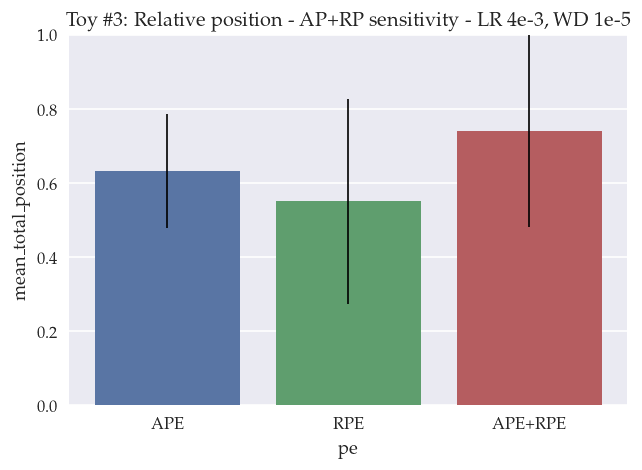

In [37]:
plot_df = df.copy()
plot_df = plot_df[plot_df['lr'] == 4e-3]
plot_df = plot_df[plot_df['weight_decay'] == 1e-5]

# Make barplot: x = pe, y = mean_total_position, yerr = std_total_position
fig, axs = plt.subplots(1, 1, figsize=(6, 4), dpi=120)
axs.set_ylim([0, 1])
axs.set_xlabel('Position encoding')
axs.set_ylabel('AP+RP sensitivity (mean over 20 seeds)')
axs.set_title('Toy \#3: Relative position - AP+RP sensitivity - LR 4e-3, WD 1e-5')
ax = sns.barplot(data=plot_df, x='pe', y='mean_total_position', ax=axs)
x_coords = [p.get_x() + 0.5 * p.get_width() for p in ax.patches]
y_coords = [p.get_height() for p in ax.patches]
ax.errorbar(x=x_coords, y=y_coords, yerr=plot_df["std_total_position"], fmt="none", c="k", elinewidth=1)

### Debug APE+RPE with updated model def and WD

In [14]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
# seeds = ]
n_epochs = 1000
report_every_n = 1000
aggregate_fn = 'sum'
weight_decay = 1e-4

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', aggregate_fn=aggregate_fn, weight_decay=weight_decay)

Epoch 0: 0.7014656066894531
Epoch 999: 8.627875649835914e-05
Accuracy: 1.0
Epoch 0: 0.8507964015007019
Epoch 999: 9.296712960349396e-05
Accuracy: 1.0
Epoch 0: 0.6966371536254883
Epoch 999: 8.598126441938803e-05
Accuracy: 1.0
Epoch 0: 0.6924664378166199
Epoch 999: 7.956549234222621e-05
Accuracy: 1.0
Epoch 0: 0.7062963843345642
Epoch 999: 0.00013938821211922914
Accuracy: 1.0
Epoch 0: 0.9457130432128906
Epoch 999: 0.00011576834367588162
Accuracy: 1.0
Epoch 0: 1.4982295036315918
Epoch 999: 0.0001805003557819873
Accuracy: 1.0
Epoch 0: 0.7601569890975952
Epoch 999: 7.136815111152828e-05
Accuracy: 1.0
Epoch 0: 0.8198745846748352
Epoch 999: 9.758117084857076e-05
Accuracy: 1.0
Epoch 0: 0.7629585266113281
Epoch 999: 9.117305307881907e-05
Accuracy: 1.0
Sorting by appearance for these groups of classes:  [range(0, 2)]

Without bias:
appearance (all): 18.16 +- 9.30 (24.97, 12.18, 13.63, 7.42, 0.94, 17.51, 23.76, 22.71, 24.22, 34.31)
appearance (c0) : 15.20 +- 8.55 (13.54, 11.20, 13.01, 5.21, 0.71, 

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Debug RPE with updated model def and WD

In [13]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True
# pos_emb = 'absolute'
# use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
# seeds = ]
n_epochs = 1000
report_every_n = 1000
aggregate_fn = 'sum'
weight_decay = 1e-4

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', aggregate_fn=aggregate_fn, weight_decay=weight_decay)

Epoch 0: 0.810307502746582
Epoch 999: 0.00011219060252187774
Accuracy: 1.0
Epoch 0: 0.6898248791694641
Epoch 999: 0.00011661156167974696
Accuracy: 1.0
Epoch 0: 0.9365790486335754
Epoch 999: 0.0002995453542098403
Accuracy: 1.0
Epoch 0: 0.698155403137207
Epoch 999: 0.00011278764577582479
Accuracy: 1.0
Epoch 0: 0.6877003908157349
Epoch 999: 9.289286390412599e-05
Accuracy: 1.0
Epoch 0: 0.6847102642059326
Epoch 999: 0.00044575330684892833
Accuracy: 1.0
Epoch 0: 0.7013127207756042
Epoch 999: 0.00038196504465304315
Accuracy: 1.0
Epoch 0: 0.8182007670402527
Epoch 999: 0.00017961292178370059
Accuracy: 1.0
Epoch 0: 0.7993085384368896
Epoch 999: 0.00020643147581722587
Accuracy: 1.0
Epoch 0: 0.8978590369224548
Epoch 999: 0.00017819741333369166
Accuracy: 1.0
Sorting by appearance for these groups of classes:  [range(0, 2)]

Without bias:
appearance (all): 28.58 +- 21.83 (58.19, 12.69, 10.50, 37.76, 4.26, 46.15, 9.30, 10.92, 69.05, 26.98)
appearance (c0) : 24.37 +- 19.99 (37.58, 11.40, 4.43, 30.71, 

### Debug APE with updated model def and WD

In [12]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
# pos_emb = 'none'
# use_rel_pos = True
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
# seeds = ]
n_epochs = 1000
report_every_n = 1000
aggregate_fn = 'sum'
weight_decay = 1e-4

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', aggregate_fn=aggregate_fn, weight_decay=weight_decay)

Epoch 0: 0.7377412915229797
Epoch 999: 0.00023997071548365057
Accuracy: 1.0
Epoch 0: 0.6847484707832336
Epoch 999: 7.362011820077896e-05
Accuracy: 1.0
Epoch 0: 0.8379300832748413
Epoch 999: 7.499312050640583e-05
Accuracy: 1.0
Epoch 0: 0.6984044909477234
Epoch 999: 0.0007323233876377344
Accuracy: 1.0
Epoch 0: 0.7971047163009644
Epoch 999: 0.01154796127229929
Accuracy: 1.0
Epoch 0: 0.695677638053894
Epoch 999: 8.197434362955391e-05
Accuracy: 1.0
Epoch 0: 0.8176095485687256
Epoch 999: 6.596739694941789e-05
Accuracy: 1.0
Epoch 0: 0.683112621307373
Epoch 999: 0.00019023308414034545
Accuracy: 1.0
Epoch 0: 0.7132396697998047
Epoch 999: 0.000380796060198918
Accuracy: 1.0
Epoch 0: 0.7980180978775024
Epoch 999: 3.7011373933637515e-05
Accuracy: 1.0
Sorting by appearance for these groups of classes:  [range(0, 2)]

Without bias:
appearance (all): 21.69 +- 15.34 (9.35, 25.75, 12.98, 1.21, 11.09, 9.64, 24.98, 29.60, 37.23, 55.11)
appearance (c0) : 17.41 +- 14.58 (6.10, 19.69, 8.48, 1.18, 7.87, 9.37,

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Plot samples with sensitivities, sorted

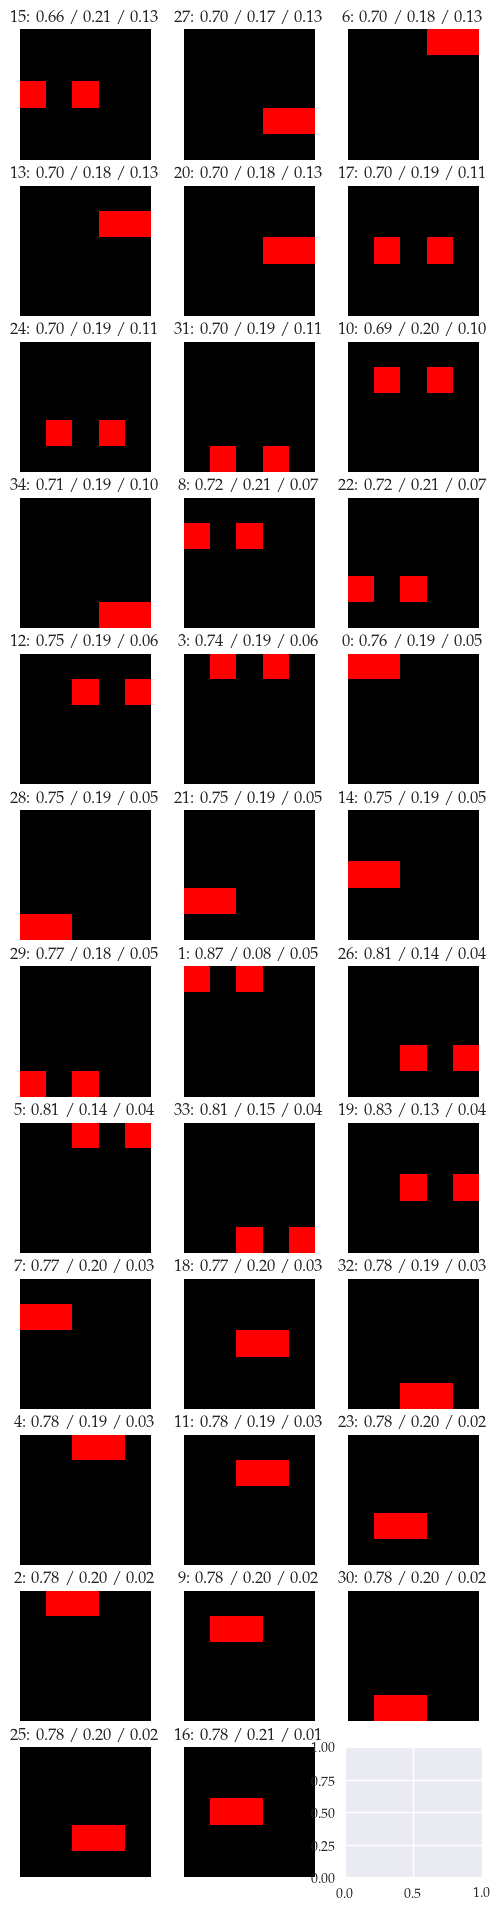

In [14]:
%autoreload
from utils import toy_analysis

seed = 1

n = len(analysis_images)
fig, axs = plt.subplots(n // 3 + 1, 3, figsize=(6, (n // 3 + 1) * 2))

biases = []
for i in range(len(analysis_images)):
    biases.append((i, toy_analysis(['pred_class'], 'scalar', 1, seed, None, model, analysis_images[i:i+1], analysis_labels[i:i+1], sources_available=['image', 'bias', 'relpos'], exclude_bias=False, attribution_method='input_gradient_withnegative')))

biases = sorted(biases, key=lambda x: x[1]['relative_position'], reverse=True)

for j, (i, sample_biases) in enumerate(biases):
    # print(f"{i}: {sample_biases['bias']:.2f} / {sample_biases['appearance']:.2f} / {sample_biases['relative_position']:.2f}")
    # print(f"{i}: {sample_biases['appearance']:.2f} / {sample_biases['relative_position']:.2f}")
    axs[j // 3, j % 3].imshow(analysis_images[i].permute(1, 2, 0))
    # axs[j // 3, j % 3].set_title(f"{i}: {sample_biases['appearance']:.2f} / {sample_biases['relative_position']:.2f}")
    axs[j // 3, j % 3].set_title(f"{i}: {sample_biases['bias']:.2f} / {sample_biases['appearance']:.2f} / {sample_biases['relative_position']:.2f}")
    axs[j // 3, j % 3].axis('off')

#### Visualize maps

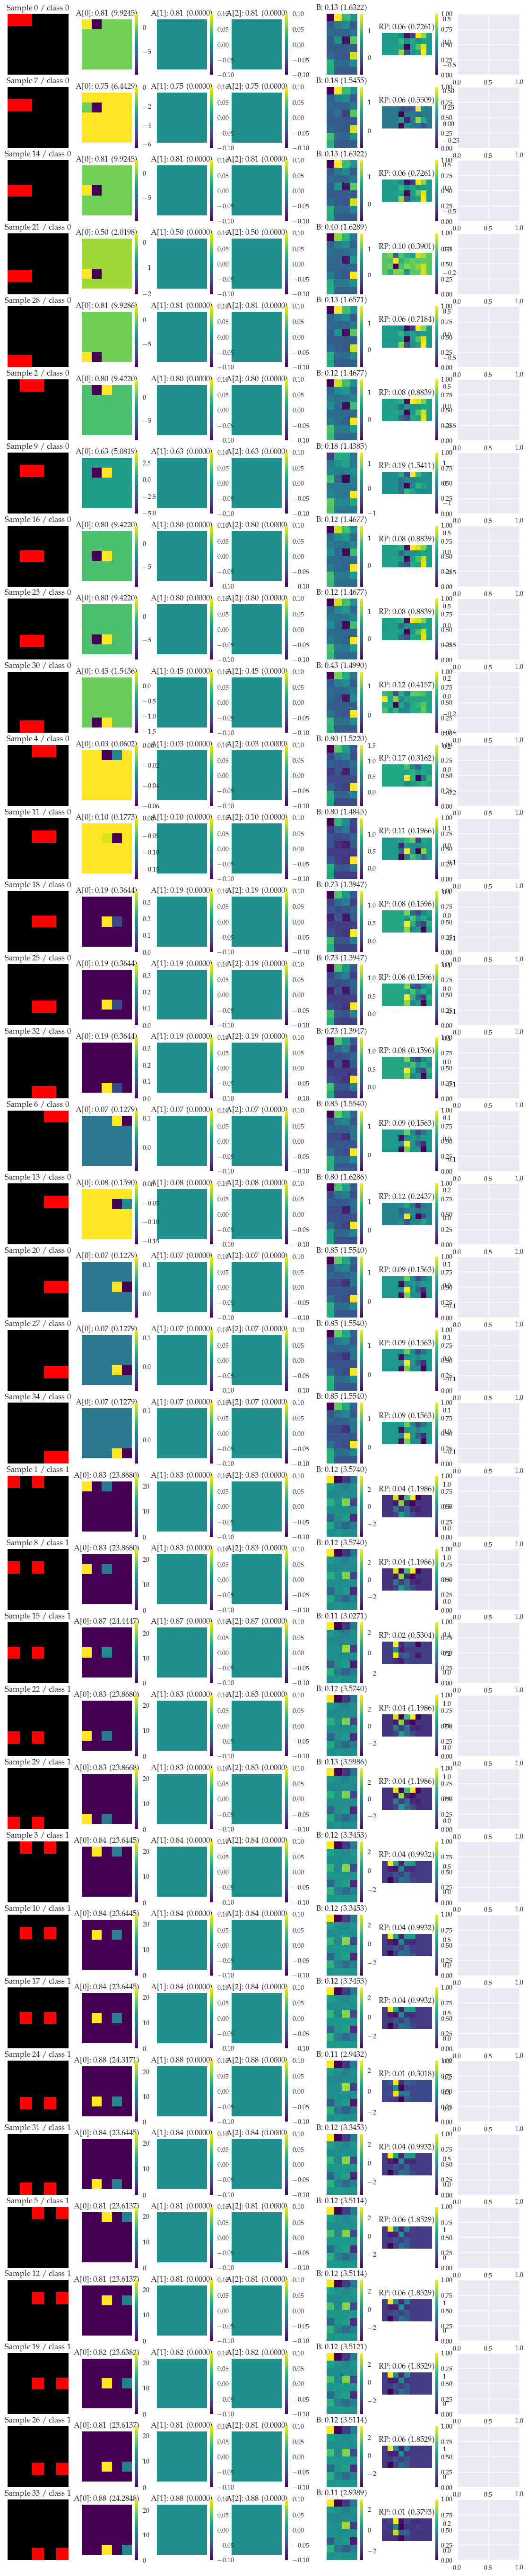

In [21]:
%autoreload
from utils import visualize_sensitivities

seed = 1
aggregate_fn = 'max'

n = len(analysis_images)
# n = 10
manual_sort = [
    0, 7, 14, 21, 28,
    2, 9, 16, 23, 30,
    4, 11, 18, 25, 32,
    6, 13, 20, 27, 34,
    1, 8, 15, 22, 29,
    3, 10, 17, 24, 31,
    5, 12, 19, 26, 33,
]

visualize_sensitivities(model, seed, analysis_images, analysis_labels, ape=False, rpe=True, manual_sort=manual_sort, n=n, aggregate_fn=aggregate_fn)


### Debug APE

In [35]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
seeds = [1]
n_epochs = 1000
report_every_n = 250
aggregate_fn = 'sum'

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', aggregate_fn=aggregate_fn)

Epoch 0: 0.7595707178115845
Epoch 250: 0.6829051375389099
Epoch 500: 9.207959374180064e-05
Epoch 750: 3.221623774152249e-05
Epoch 999: 1.8191034541814588e-05
Accuracy: 1.0
all classes, no bias
image activations L2 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
pos_emb activations L2 [19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242]
image gradients L2 [-94.173416, -7.583746, -94.05869, 74.009384, -53.1174, -7.4255886, -57.450413, -48.25642, -7.562621, -48.866566, 77.69853, -98.23836, -7.5816097, -96.42081, -93.54918, -7.5819, -94.888794, 72.514626, -58.266724, -7.5

/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


image activations L2 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
pos_emb activations L2 [19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242, 19.49242]
image gradients L2 [-94.173416, -94.05869, -53.1174, -57.450413, -48.25642, -48.866566, -98.23836, -96.42081, -93.54918, -94.888794, -58.266724, -55.267338, -96.60434, -96.63371, -46.91852, -45.143135, -96.515114, -97.38979, -43.68391, -43.821346]
pos_emb gradients L2 [-27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274, -27.292274]
norm_term tensor([72.8710, 72.8765, 56.7919, 58.2033, 54.8220, 54.9001, 73.3892, 73.2802,
        72.1873, 72.2031, 58.8394, 58.3006, 73.0968, 7

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Visualize maps

KeyboardInterrupt: 

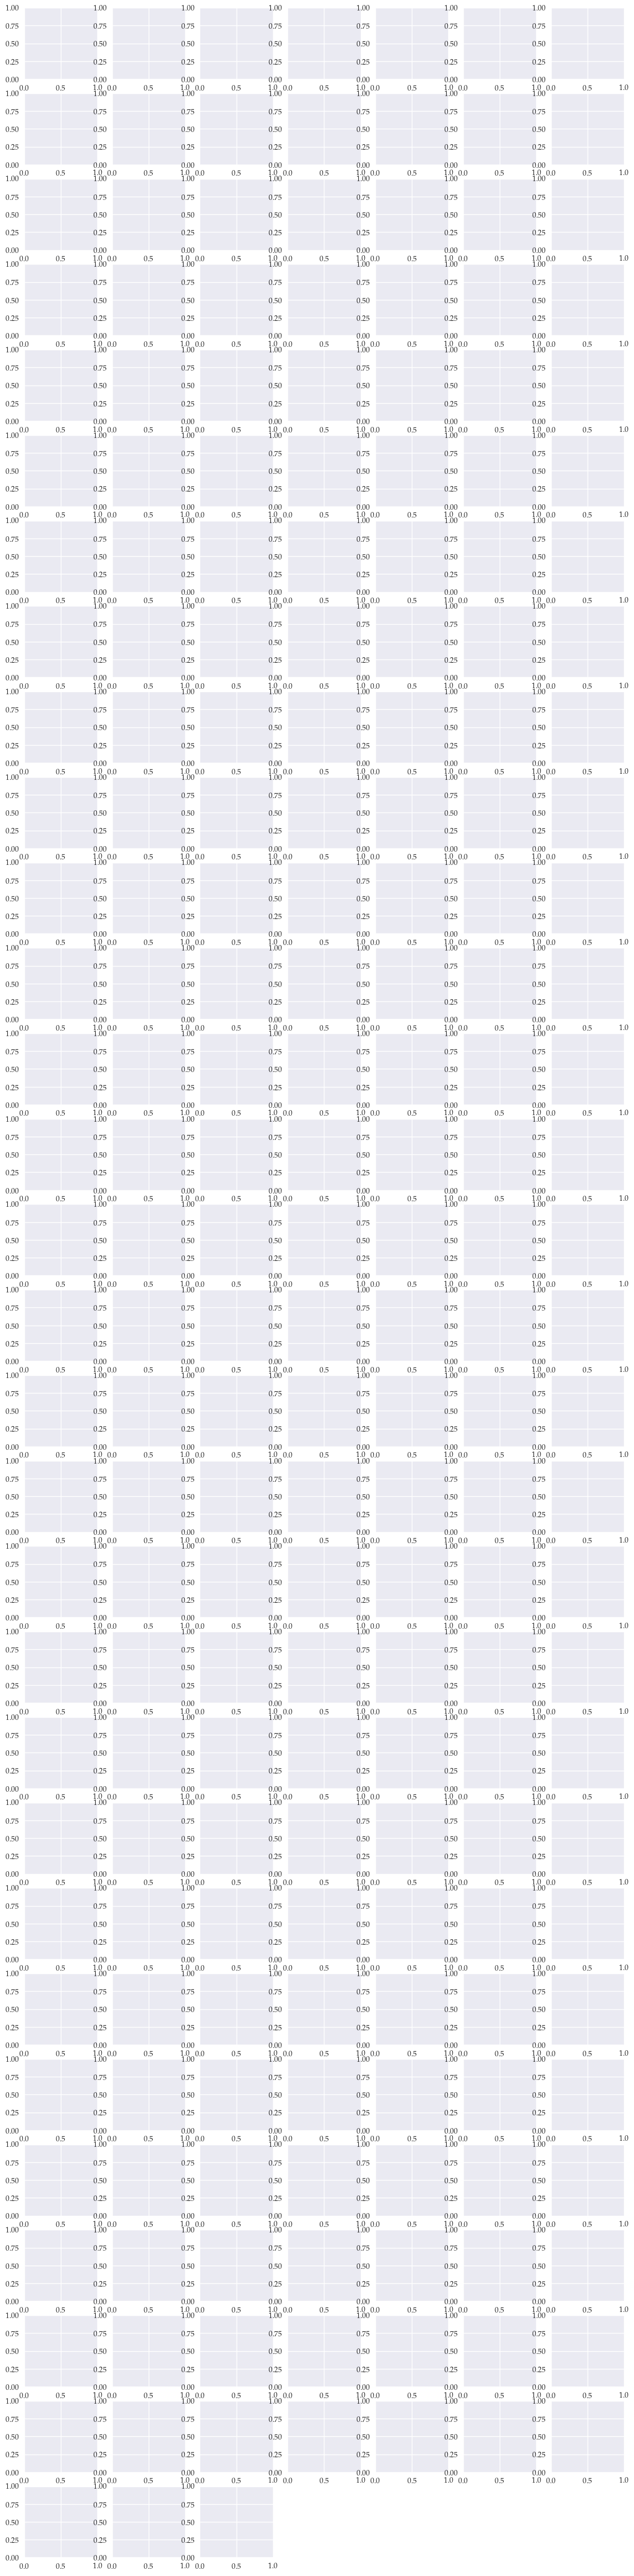

In [37]:
%autoreload
from utils import visualize_sensitivities

seed = 1
aggregate_fn = 'max'
plot_codomain = 'none'

n = len(analysis_images)
# n = 10
manual_sort = [
    0, 7, 14, 21, 28,
    2, 9, 16, 23, 30,
    4, 11, 18, 25, 32,
    6, 13, 20, 27, 34,
    1, 8, 15, 22, 29,
    3, 10, 17, 24, 31,
    5, 12, 19, 26, 33,
]

visualize_sensitivities(model, seed, analysis_images, analysis_labels, ape=True, rpe=False, manual_sort=manual_sort, n=n, aggregate_fn=aggregate_fn, plot_codomain=plot_codomain)

### No PE - with negative

In [20]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# Test these settings
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.7841150760650635
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7336781024932861
Epoch 2000: 0.6829081773757935
Epoch 3999: 0.6829080581665039
Accuracy: 0.5714285969734192
Epoch 0: 0.6865953207015991
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.791488766670227
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.7225820422172546
Epoch 2000: 0.6829080581665039
Epoch 3999: 0.6829080581665039
Accuracy: 0.5714285969734192
Epoch 0: 0.6861563324928284
Epoch 2000: 0.6829080581665039
Epoch 3999: 0.6829080581665039
Accuracy: 0.5714285969734192
Epoch 0: 0.6839022636413574
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7296363115310669
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7468795776367188
Epoch 2000: 0.6829080

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### No PE

In [23]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = False

# Test these settings
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.7841150760650635
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7336781024932861
Epoch 2000: 0.6829081773757935
Epoch 3999: 0.6829080581665039
Accuracy: 0.5714285969734192
Epoch 0: 0.6865953207015991
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.791488766670227
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.7225820422172546
Epoch 2000: 0.6829080581665039
Epoch 3999: 0.6829080581665039
Accuracy: 0.5714285969734192
Epoch 0: 0.6861563324928284
Epoch 2000: 0.6829080581665039
Epoch 3999: 0.6829080581665039
Accuracy: 0.5714285969734192
Epoch 0: 0.6839022636413574
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7296363115310669
Epoch 2000: 0.6829081177711487
Epoch 3999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7468795776367188
Epoch 2000: 0.6829080

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### APE - fix zero grad

In [7]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
# seeds = [0]
n_epochs = 1000
report_every_n = 250

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6869686841964722
Epoch 250: 0.17890262603759766
Epoch 500: 0.0009754736674949527
Epoch 750: 0.00029367467504926026
Epoch 999: 0.0001439541665604338
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.7595707178115845
Epoch 250: 0.6829051375389099
Epoch 500: 9.207959374180064e-05
Epoch 750: 3.221623774152249e-05
Epoch 999: 1.8191034541814588e-05
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 250: 0.291692852973938
Epoch 500: 6.495139678008854e-05
Epoch 750: 2.2634056222159415e-05
Epoch 999: 1.1923763850063551e-05
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 250: 4.7021243517519906e-05
Epoch 500: 1.7713753550196998e-05
Epoch 750: 9.478638276050333e-06
Epoch 999: 5.916110694670351e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6133426427841187
Epoch 500: 0.0007970539736561477
Epoch 750: 0.0002894150384236127
Epoch 999: 0.0001524483086541295
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 250: 0.0014058430679142475
Epoch 500: 0.00034796158433891833
Epoch 750: 0.00016223109560087323
Epoch 999: 9.466819756198674e-05
Accuracy: 1.0
Epoch 0: 0.683094322681427
Epoch 250: 0.0008762633660808206
Epoch 500: 0.00016655083163641393
Epoch 750: 7.30174797354266e-05
Epoch 9

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

### APE with WD

In [29]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
# seeds = [0]
report_every_n = 250
n_epochs = 1000
d = 4
n_heads = 2
lr = 4e-3
weight_decay = 0.

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.6869686841964722
Epoch 250: 0.17890262603759766
Epoch 500: 0.0009754736674949527
Epoch 750: 0.00029367467504926026
Epoch 999: 0.0001439541665604338
Accuracy: 1.0
Epoch 0: 0.7595707178115845
Epoch 250: 0.6829051375389099
Epoch 500: 9.207959374180064e-05
Epoch 750: 3.221623774152249e-05
Epoch 999: 1.8191034541814588e-05
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 250: 0.291692852973938
Epoch 500: 6.495139678008854e-05
Epoch 750: 2.2634056222159415e-05
Epoch 999: 1.1923763850063551e-05
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 250: 4.7021243517519906e-05
Epoch 500: 1.7713753550196998e-05
Epoch 750: 9.478638276050333e-06
Epoch 999: 5.916110694670351e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6133426427841187
Epoch 500: 0.0007970539736561477
Epoch 750: 0.0002894150384236127
Epoch 999: 0.0001524483086541295
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 250: 0.0014058430679142475
Epoch 500: 0.00034796158433891833
Epoch 750: 0.00016223109560087323
Epoch 9

TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

In [30]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
# seeds = [0]
report_every_n = 250
n_epochs = 1000
d = 4
n_heads = 2
lr = 4e-3
weight_decay = 1e-5

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.6869686841964722
Epoch 250: 0.6829080581665039
Epoch 500: 0.6829081177711487
Epoch 750: 0.6829080581665039
Epoch 999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.7595707178115845
Epoch 250: 0.6829081177711487
Epoch 500: 0.6829081177711487
Epoch 750: 0.6829080581665039
Epoch 999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7516001462936401
Epoch 250: 0.6829079985618591
Epoch 500: 0.6829082369804382
Epoch 750: 0.6829080581665039
Epoch 999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.6829089522361755
Epoch 250: 0.00014826895494479686
Epoch 500: 2.712006971705705e-05
Epoch 750: 9.815827979764435e-06
Epoch 999: 5.34733226231765e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6829081177711487
Epoch 500: 0.6829079985618591
Epoch 750: 0.6829080581665039
Epoch 999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.6837638020515442
Epoch 250: 0.6829080581665039
Epoch 500: 0.6829080581665039
Epoch 750: 0.6829080581665039


TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

In [37]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
# seeds = [0]
report_every_n = 250
n_epochs = 1000
d = 4
n_heads = 2
lr = 4e-3
weight_decay = 1e-6

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.6869686841964722
Epoch 250: 0.204173281788826
Epoch 500: 0.0014128616312518716
Epoch 750: 0.00040069370879791677
Epoch 999: 0.00018981509492732584
Accuracy: 1.0
Epoch 0: 0.7595707178115845
Epoch 250: 0.6829069256782532
Epoch 500: 0.21912285685539246
Epoch 750: 0.0007067255792208016
Epoch 999: 0.00018000132695306093
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 250: 0.38945987820625305
Epoch 500: 7.694026862736791e-06
Epoch 750: 4.342595730122412e-06
Epoch 999: 2.9768123113171896e-06
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 250: 3.931920218747109e-05
Epoch 500: 1.4761133570573293e-05
Epoch 750: 8.177645213436335e-06
Epoch 999: 5.255381893221056e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6607853174209595
Epoch 500: 0.0008181777084246278
Epoch 750: 0.0002937880635727197
Epoch 999: 0.00015452264051418751
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 250: 0.001576320268213749
Epoch 500: 0.0004023553046863526
Epoch 750: 0.00018969012307934463
Epoch 999: 

TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

In [38]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
# seeds = [0]
report_every_n = 250
n_epochs = 1000
d = 4
n_heads = 2
lr = 4e-3
weight_decay = 1e-7

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.6869686841964722
Epoch 250: 0.12662562727928162
Epoch 500: 0.0007749234209768474
Epoch 750: 0.0002401298115728423
Epoch 999: 0.00011787955008912832
Accuracy: 1.0
Epoch 0: 0.7595707178115845
Epoch 250: 0.6829054951667786
Epoch 500: 0.00010011334234150127
Epoch 750: 3.432106677792035e-05
Epoch 999: 1.9216218788642436e-05
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 250: 0.2971023619174957
Epoch 500: 0.00010661365377018228
Epoch 750: 3.467382339295e-05
Epoch 999: 1.7464381016907282e-05
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 250: 5.455417704069987e-05
Epoch 500: 1.956659252755344e-05
Epoch 750: 1.034376418829197e-05
Epoch 999: 6.413388746295823e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6188157200813293
Epoch 500: 0.0008240692550316453
Epoch 750: 0.000298405735520646
Epoch 999: 0.0001571872126078233
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 250: 0.0012508690124377608
Epoch 500: 0.00032573414500802755
Epoch 750: 0.0001540727389510721
Epoch 999: 9

TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

In [31]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
# seeds = [0]
report_every_n = 250
n_epochs = 1000
d = 4
n_heads = 2
lr = 4e-3
weight_decay = 1e-8

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.6869686841964722
Epoch 250: 0.11463375389575958
Epoch 500: 0.0007953745662234724
Epoch 750: 0.0002463064156472683
Epoch 999: 0.00012082453758921474
Accuracy: 1.0
Epoch 0: 0.7595707178115845
Epoch 250: 0.6829050779342651
Epoch 500: 0.00012612382124643773
Epoch 750: 4.337357677286491e-05
Epoch 999: 2.347013469261583e-05
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 250: 0.29733338952064514
Epoch 500: 3.0358734875335358e-05
Epoch 750: 1.4110472875472624e-05
Epoch 999: 8.15374733065255e-06
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 250: 5.862849866389297e-05
Epoch 500: 2.1378180463216268e-05
Epoch 750: 1.1178130080224946e-05
Epoch 999: 6.866350759082707e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6183618307113647
Epoch 500: 0.000798263936303556
Epoch 750: 0.0002902285195887089
Epoch 999: 0.00015299215738195926
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 250: 0.0013646732550114393
Epoch 500: 0.00034304638393223286
Epoch 750: 0.00016117554332595319
Epoch 

TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

### APE with negative

In [12]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
# seeds = [0]
n_epochs = 1000
report_every_n = 250

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6869686841964722
Epoch 250: 0.17890262603759766
Epoch 500: 0.0009754736674949527
Epoch 750: 0.00029367467504926026
Epoch 999: 0.0001439541665604338
Accuracy: 1.0


/home/robert-jan/surfdrive/experiments/vit-position-info/toy-experiments/../analysis/learned_relative_position.py:170: RuntimeWarning: Mean of empty slice.
  return sf.mean()
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 0: 0.7595707178115845
Epoch 250: 0.6829051375389099
Epoch 500: 9.207959374180064e-05
Epoch 750: 3.221623774152249e-05
Epoch 999: 1.8191034541814588e-05
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 250: 0.291692852973938
Epoch 500: 6.495139678008854e-05
Epoch 750: 2.2634056222159415e-05
Epoch 999: 1.1923763850063551e-05
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 250: 4.7021243517519906e-05
Epoch 500: 1.7713753550196998e-05
Epoch 750: 9.478638276050333e-06
Epoch 999: 5.916110694670351e-06
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 250: 0.6133426427841187
Epoch 500: 0.0007970539736561477
Epoch 750: 0.0002894150384236127
Epoch 999: 0.0001524483086541295
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 250: 0.0014058430679142475
Epoch 500: 0.00034796158433891833
Epoch 750: 0.00016223109560087323
Epoch 999: 9.466819756198674e-05
Accuracy: 1.0
Epoch 0: 0.683094322681427
Epoch 250: 0.0008762633660808206
Epoch 500: 0.00016655083163641393
Epoch 750: 7.30174797354266e-05
Epoch 9

/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/robert-jan/miniconda3/envs/vit/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_features=2, bias=True)
)

### APE

In [12]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = False

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.6869686841964722
Epoch 2000: 2.8299211408011615e-05
Epoch 3999: 4.727468422061065e-06
Accuracy: 1.0
Epoch 0: 0.7595707178115845
Epoch 2000: 4.352824817033252e-06
Epoch 3999: 7.867807880757027e-07
Accuracy: 1.0
Epoch 0: 0.7516001462936401
Epoch 2000: 2.615765879454557e-06
Epoch 3999: 4.564004427720647e-07
Accuracy: 1.0
Epoch 0: 0.6829089522361755
Epoch 2000: 1.6382711010010098e-06
Epoch 3999: 3.3378586294929846e-07
Accuracy: 1.0
Epoch 0: 0.7071390748023987
Epoch 2000: 3.339325121487491e-05
Epoch 3999: 5.933138254476944e-06
Accuracy: 1.0
Epoch 0: 0.6837638020515442
Epoch 2000: 2.3841361326049082e-05
Epoch 3999: 4.584430371323833e-06
Accuracy: 1.0
Epoch 0: 0.683094322681427
Epoch 2000: 9.720611160446424e-06
Epoch 3999: 1.7506716858406435e-06
Accuracy: 1.0
Epoch 0: 0.6833924651145935
Epoch 2000: 1.181871311928262e-06
Epoch 3999: 2.3501246460000402e-07
Accuracy: 1.0
Epoch 0: 0.683946430683136
Epoch 2000: 5.779911589343101e-06
Epoch 3999: 1.0320106866856804e-06
Accuracy: 1.0
Epoch

LR 4e-3

Without bias:
appearance (all): 26.13 +- 14.78 (15.49, 4.57, 16.80, 32.51, 7.73, 45.35, 26.36, 22.63, 39.91, 49.98)
appearance (c0) : 8.62 +- 12.29 (2.39, 0.00, 0.00, 0.00, 1.81, 10.86, 4.75, 8.33, 15.81, 42.24)
appearance (c1) : 45.82 +- 19.86 (18.71, 15.99, 29.41, 73.80, 61.95, 38.05, 68.05, 39.33, 46.91, 66.01)
position (all): 73.87 +- 14.78 (84.51, 95.43, 83.20, 67.49, 92.27, 54.65, 73.64, 77.37, 60.09, 50.02)
position (c0) : 91.38 +- 12.29 (97.61, 100.00, 100.00, 100.00, 98.19, 89.14, 95.25, 91.67, 84.19, 57.76)
position (c1) : 54.18 +- 19.86 (81.29, 84.01, 70.59, 26.20, 38.05, 61.95, 31.95, 60.67, 53.09, 33.99)

With bias:
bias (all): 40.16 +- 20.99 (54.06, 22.68, 49.03, 32.16, 23.08, 91.88, 34.37, 17.89, 49.61, 26.81)
bias (c0) : 57.88 +- 26.81 (76.96, 16.27, 77.68, 53.78, 19.26, 92.85, 46.99, 93.22, 66.76, 35.02)
bias (c1) : 27.92 +- 20.48 (13.89, 42.47, 24.01, 3.25, 65.72, 61.80, 21.18, 7.99, 19.18, 19.69)
appearance (all): 18.29 +- 12.87 (11.13, 1.91, 14.47, 31.42, 4.82, 5.60, 21.11, 20.78, 26.42, 45.24)
appearance (c0) : 5.32 +- 10.78 (0.55, 0.00, 0.00, 0.00, 1.53, 3.84, 2.90, 0.65, 6.63, 37.06)
appearance (c1) : 32.75 +- 22.01 (15.93, 5.17, 25.32, 71.39, 16.54, 5.13, 53.77, 36.19, 37.94, 60.09)
position (all): 41.55 +- 21.44 (34.82, 75.41, 36.50, 36.42, 72.10, 2.52, 44.51, 61.33, 23.97, 27.96)
position (c0) : 36.81 +- 26.32 (22.49, 83.72, 22.32, 46.22, 79.22, 3.32, 50.11, 6.13, 26.61, 27.92)
position (c1) : 39.33 +- 16.75 (70.18, 52.36, 50.67, 25.36, 17.74, 33.07, 25.05, 55.82, 42.88, 20.22)

### RPE - fix zero grad

In [8]:
%autoreload

# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.8353761434555054
Epoch 2000: 3.81282479793299e-05
Epoch 3999: 6.7097271312377416e-06
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 2000: 1.866473326117557e-06
Epoch 3999: 3.6784570056624943e-07
Accuracy: 1.0
Epoch 0: 0.6897980570793152
Epoch 2000: 2.469328364895773e-06
Epoch 3999: 5.143027124177024e-07
Accuracy: 1.0
Epoch 0: 0.7091425657272339
Epoch 2000: 1.961841462616576e-06
Epoch 3999: 3.269740034284041e-07
Accuracy: 1.0
Epoch 0: 0.6833635568618774
Epoch 2000: 4.240430826030206e-06
Epoch 3999: 7.867809017625405e-07
Accuracy: 1.0
Epoch 0: 0.7043377757072449
Epoch 2000: 4.114413968636654e-06
Epoch 3999: 7.356914011324989e-07
Accuracy: 1.0
Epoch 0: 0.7012134790420532
Epoch 2000: 2.2479439394373912e-06
Epoch 3999: 4.087175113909325e-07
Accuracy: 1.0
Epoch 0: 0.8064528107643127
Epoch 2000: 4.942053692502668e-06
Epoch 3999: 9.093958510675293e-07
Accuracy: 1.0
Epoch 0: 0.6830626726150513
Epoch 2000: 2.6089753646374447e-06
Epoch 3999: 4.870549901170307e-07
Accuracy: 1.0
Epoch 0

### RPE with WD

In [32]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
weight_decay = 0.
# seeds = [0]
n_epochs = 1000
report_every_n = 250

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.8353761434555054
Epoch 250: 0.006285143084824085
Epoch 500: 0.0008281441987492144
Epoch 750: 0.00032625044696033
Epoch 999: 0.0001744119799695909
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 250: 4.845829607802443e-05
Epoch 500: 2.1113277398399077e-05
Epoch 750: 1.1379261195543222e-05
Epoch 999: 7.009460659901379e-06
Accuracy: 1.0
Epoch 0: 0.6897980570793152
Epoch 250: 6.543229392264038e-05
Epoch 500: 2.6719288143794984e-05
Epoch 750: 1.4298109817900695e-05
Epoch 999: 8.933803655963857e-06
Accuracy: 1.0
Epoch 0: 0.7091425657272339
Epoch 250: 0.00019947394321206957
Epoch 500: 4.110890586161986e-05
Epoch 750: 1.7142076103482395e-05
Epoch 999: 9.264201253245119e-06
Accuracy: 1.0
Epoch 0: 0.6833635568618774
Epoch 250: 0.00019548897398635745
Epoch 500: 6.0136164393043146e-05
Epoch 750: 2.872192817449104e-05
Epoch 999: 1.6798057913547382e-05
Accuracy: 1.0
Epoch 0: 0.7043377757072449
Epoch 250: 0.00014546787133440375
Epoch 500: 5.4790350986877456e-05
Epoch 750: 2.774469066935125

In [33]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
weight_decay = 1e-2
# seeds = [0]
n_epochs = 1000
report_every_n = 250

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.8353761434555054
Epoch 250: 0.6830135583877563
Epoch 500: 0.6829439401626587
Epoch 750: 0.682916522026062
Epoch 999: 0.6829125285148621
Accuracy: 0.5714285969734192
Epoch 0: 0.6899478435516357
Epoch 250: 0.682914137840271
Epoch 500: 0.6829125881195068
Epoch 750: 0.682912290096283
Epoch 999: 0.6829121708869934
Accuracy: 0.5714285969734192
Epoch 0: 0.6897980570793152
Epoch 250: 0.6829122304916382
Epoch 500: 0.6829120516777039
Epoch 750: 0.6829121708869934
Epoch 999: 0.6829122304916382
Accuracy: 0.5714285969734192
Epoch 0: 0.7091425657272339
Epoch 250: 0.6829144954681396
Epoch 500: 0.6829125285148621
Epoch 750: 0.682912290096283
Epoch 999: 0.6829122304916382
Accuracy: 0.5714285969734192
Epoch 0: 0.6833635568618774
Epoch 250: 0.6829120516777039
Epoch 500: 0.6829122304916382
Epoch 750: 0.6829122304916382
Epoch 999: 0.6829122304916382
Accuracy: 0.5714285969734192
Epoch 0: 0.7043377757072449
Epoch 250: 0.6829163432121277
Epoch 500: 0.6829121112823486
Epoch 750: 0.6829121112823486
E

In [34]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
weight_decay = 1e-3
# seeds = [0]
n_epochs = 1000
report_every_n = 250

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.8353761434555054
Epoch 250: 0.0039906264282763
Epoch 500: 0.0004975559422746301
Epoch 750: 0.00047708553029224277
Epoch 999: 0.00044014956802129745
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 250: 0.6829084753990173
Epoch 500: 0.6829082369804382
Epoch 750: 0.6829080581665039
Epoch 999: 0.6829081773757935
Accuracy: 0.5714285969734192
Epoch 0: 0.6897980570793152
Epoch 250: 0.6829081177711487
Epoch 500: 0.6829081177711487
Epoch 750: 0.6829081177711487
Epoch 999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7091425657272339
Epoch 250: 0.682908296585083
Epoch 500: 0.6829081773757935
Epoch 750: 0.6829081773757935
Epoch 999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.6833635568618774
Epoch 250: 0.6829081773757935
Epoch 500: 0.6829080581665039
Epoch 750: 0.6829081773757935
Epoch 999: 0.6829081177711487
Accuracy: 0.5714285969734192
Epoch 0: 0.7043377757072449
Epoch 250: 0.6829094886779785
Epoch 500: 0.6829084157943726
Epoch 750: 0.682908296585083
Epo

In [35]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
weight_decay = 1e-4
# seeds = [0]
n_epochs = 1000
report_every_n = 250

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.8353761434555054
Epoch 250: 0.00018730974989011884
Epoch 500: 6.376740202540532e-05
Epoch 750: 4.6241657400969416e-05
Epoch 999: 4.2181971366517246e-05
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 250: 8.365527173737064e-05
Epoch 500: 4.6404838940361515e-05
Epoch 750: 4.027114846394397e-05
Epoch 999: 3.9787584682926536e-05
Accuracy: 1.0
Epoch 0: 0.6897980570793152
Epoch 250: 3.5635945096146315e-05
Epoch 500: 2.945436062873341e-05
Epoch 750: 2.9444168831105344e-05
Epoch 999: 3.0408027669182047e-05
Accuracy: 1.0
Epoch 0: 0.7091425657272339
Epoch 250: 0.00022195084602572024
Epoch 500: 6.965577631490305e-05
Epoch 750: 4.9906186177395284e-05
Epoch 999: 4.700449062511325e-05
Accuracy: 1.0
Epoch 0: 0.6833635568618774
Epoch 250: 0.0002014751371461898
Epoch 500: 9.210982534568757e-05
Epoch 750: 6.597632454941049e-05
Epoch 999: 5.729889016947709e-05
Accuracy: 1.0
Epoch 0: 0.7043377757072449
Epoch 250: 0.003468303242698312
Epoch 500: 0.0006005133618600667
Epoch 750: 0.00028833228861

In [36]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2
weight_decay = 1e-5
# seeds = [0]
n_epochs = 1000
report_every_n = 250

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative', weight_decay=weight_decay)

Epoch 0: 0.8353761434555054
Epoch 250: 0.006513359025120735
Epoch 500: 0.0008203790057450533
Epoch 750: 0.00032415727037005126
Epoch 999: 0.0001754333352437243
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 250: 4.9000158469425514e-05
Epoch 500: 2.3041093299980275e-05
Epoch 750: 1.3787280295218807e-05
Epoch 999: 9.601398232916836e-06
Accuracy: 1.0
Epoch 0: 0.6897980570793152
Epoch 250: 7.125314004952088e-05
Epoch 500: 3.069065496674739e-05
Epoch 750: 1.7305586879956536e-05
Epoch 999: 1.1522341083036736e-05
Accuracy: 1.0
Epoch 0: 0.7091425657272339
Epoch 250: 0.00020030142331961542
Epoch 500: 4.314897159929387e-05
Epoch 750: 1.9349099602550268e-05
Epoch 999: 1.1512116543599404e-05
Accuracy: 1.0
Epoch 0: 0.6833635568618774
Epoch 250: 0.00020125764422118664
Epoch 500: 6.711749301757663e-05
Epoch 750: 3.3919121051440015e-05
Epoch 999: 2.0980449335183948e-05
Accuracy: 1.0
Epoch 0: 0.7043377757072449
Epoch 250: 0.00013823177141603082
Epoch 500: 5.4313608416123316e-05
Epoch 750: 2.8957203539

### RPE with negative

In [22]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

model = run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.8353761434555054
Epoch 2000: 3.81282479793299e-05
Epoch 3999: 6.7097271312377416e-06
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 2000: 1.866473326117557e-06
Epoch 3999: 3.6784570056624943e-07
Accuracy: 1.0
Epoch 0: 0.6897980570793152
Epoch 2000: 2.469328364895773e-06
Epoch 3999: 5.143027124177024e-07
Accuracy: 1.0
Epoch 0: 0.7091425657272339
Epoch 2000: 1.961841462616576e-06
Epoch 3999: 3.269740034284041e-07
Accuracy: 1.0
Epoch 0: 0.6833635568618774
Epoch 2000: 4.240430826030206e-06
Epoch 3999: 7.867809017625405e-07
Accuracy: 1.0
Epoch 0: 0.7043377757072449
Epoch 2000: 4.114413968636654e-06
Epoch 3999: 7.356914011324989e-07
Accuracy: 1.0
Epoch 0: 0.7012134790420532
Epoch 2000: 2.2479439394373912e-06
Epoch 3999: 4.087175113909325e-07
Accuracy: 1.0
Epoch 0: 0.8064528107643127
Epoch 2000: 4.942053692502668e-06
Epoch 3999: 9.093958510675293e-07
Accuracy: 1.0
Epoch 0: 0.6830626726150513
Epoch 2000: 2.6089753646374447e-06
Epoch 3999: 4.870549901170307e-07
Accuracy: 1.0
Epoch 0

### RPE

In [13]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'none'
use_rel_pos = True

# Test these settings
lr = 4e-3
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.8353761434555054


Epoch 2000: 3.81282479793299e-05
Epoch 3999: 6.7097271312377416e-06
Accuracy: 1.0
Epoch 0: 0.6899478435516357
Epoch 2000: 1.866473326117557e-06
Epoch 3999: 3.6784570056624943e-07
Accuracy: 1.0
Epoch 0: 0.6897980570793152
Epoch 2000: 2.469328364895773e-06
Epoch 3999: 5.143027124177024e-07
Accuracy: 1.0
Epoch 0: 0.7091425657272339
Epoch 2000: 1.961841462616576e-06
Epoch 3999: 3.269740034284041e-07
Accuracy: 1.0
Epoch 0: 0.6833635568618774
Epoch 2000: 4.240430826030206e-06
Epoch 3999: 7.867809017625405e-07
Accuracy: 1.0
Epoch 0: 0.7043377757072449
Epoch 2000: 4.114413968636654e-06
Epoch 3999: 7.356914011324989e-07
Accuracy: 1.0
Epoch 0: 0.7012134790420532
Epoch 2000: 2.2479439394373912e-06
Epoch 3999: 4.087175113909325e-07
Accuracy: 1.0
Epoch 0: 0.8064528107643127
Epoch 2000: 4.942053692502668e-06
Epoch 3999: 9.093958510675293e-07
Accuracy: 1.0
Epoch 0: 0.6830626726150513
Epoch 2000: 2.6089753646374447e-06
Epoch 3999: 4.870549901170307e-07
Accuracy: 1.0
Epoch 0: 0.6842068433761597
Epoch 2

LR 4e-3

Without bias:
appearance (all): 64.46 +- 12.77 (71.33, 59.92, 74.01, 67.39, 49.27, 53.04, 89.45, 53.73, 49.80, 76.65)
appearance (c0) : 39.00 +- 28.25 (54.66, 36.87, 64.69, 58.13, 15.74, 0.00, 83.52, 0.00, 14.36, 62.06)
appearance (c1) : 90.85 +- 5.39 (83.84, 90.65, 86.44, 79.75, 93.97, 92.83, 93.90, 94.02, 97.06, 96.09)
relative_position (all): 35.54 +- 12.77 (28.67, 40.08, 25.99, 32.61, 50.73, 46.96, 10.55, 46.27, 50.20, 23.35)
relative_position (c0) : 61.00 +- 28.25 (45.34, 63.13, 35.31, 41.87, 84.26, 100.00, 16.48, 100.00, 85.64, 37.94)
relative_position (c1) : 9.15 +- 5.39 (16.16, 9.35, 13.56, 20.25, 6.03, 7.17, 6.10, 5.98, 2.94, 3.91)

With bias:
bias (all): 45.16 +- 15.02 (77.60, 52.56, 35.48, 34.68, 41.31, 48.59, 21.75, 44.46, 60.96, 34.24)
bias (c0) : 63.34 +- 21.24 (85.84, 79.71, 46.08, 49.49, 62.34, 86.33, 25.04, 68.39, 89.79, 40.39)
bias (c1) : 25.20 +- 15.96 (71.43, 16.34, 21.34, 14.95, 13.27, 20.28, 19.29, 26.51, 22.52, 26.03)
appearance (all): 42.63 +- 12.89 (18.06, 37.66, 49.58, 45.91, 37.52, 42.26, 70.17, 39.49, 33.38, 52.27)
appearance (c0) : 19.20 +- 20.14 (10.45, 9.01, 35.75, 29.44, 4.55, 0.00, 62.68, 0.00, 2.02, 38.16)
appearance (c1) : 68.22 +- 15.36 (23.77, 75.86, 68.04, 67.87, 81.49, 73.96, 75.79, 69.10, 75.20, 71.09)
relative_position (all): 12.21 +- 5.41 (4.33, 9.78, 14.94, 19.40, 21.17, 9.15, 8.07, 16.06, 5.66, 13.49)
relative_position (c0) : 17.46 +- 9.11 (3.71, 11.28, 18.18, 21.07, 33.11, 13.67, 12.27, 31.61, 8.20, 21.45)
relative_position (c1) : 6.59 +- 4.19 (4.80, 7.79, 10.62, 17.18, 5.25, 5.76, 4.92, 4.39, 2.27, 2.88)

### APE+RPE - fix zero grad

In [9]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6955099701881409
Epoch 2000: 5.381444907470723e-07
Epoch 3999: 1.8732885109784547e-07
Accuracy: 1.0
Epoch 0: 0.7560549378395081
Epoch 2000: 1.103535623769858e-06
Epoch 3999: 2.043587272737568e-07
Accuracy: 1.0
Epoch 0: 0.708515465259552
Epoch 2000: 1.1341890058247373e-06
Epoch 3999: 2.179826168458021e-07
Accuracy: 1.0
Epoch 0: 0.7001951932907104
Epoch 2000: 2.9086988888593623e-06
Epoch 3999: 5.211147140471439e-07
Accuracy: 1.0
Epoch 0: 0.6842564940452576
Epoch 2000: 2.0299612515373155e-06
Epoch 3999: 3.780637030104117e-07
Accuracy: 1.0
Epoch 0: 0.7528617978096008
Epoch 2000: 1.9209703623346286e-06
Epoch 3999: 3.7465770219569094e-07
Accuracy: 1.0
Epoch 0: 0.8652971386909485
Epoch 2000: 2.75883780886943e-06
Epoch 3999: 5.483625500346534e-07
Accuracy: 1.0
Epoch 0: 0.8666408061981201
Epoch 2000: 2.823549493768951e-06
Epoch 3999: 5.551743811338383e-07
Accuracy: 1.0
Epoch 0: 0.6842573881149292
Epoch 2000: 3.2969785479508573e-06
Epoch 3999: 5.04084766816959e-07
Accuracy: 1.0
Epoch 

TriViTal(
  (patch_layer): Conv2d(3, 4, kernel_size=(1, 1), stride=(1, 1))
  (block1): Block(
    (attention_norm): Identity()
    (ffn_norm): Identity()
    (ffn): Mlp(
      (fc1): Linear(in_features=4, out_features=4, bias=True)
      (fc2): Linear(in_features=4, out_features=4, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (attn): Attention(
      (query): Linear(in_features=4, out_features=4, bias=True)
      (key): Linear(in_features=4, out_features=4, bias=True)
      (value): Linear(in_features=4, out_features=4, bias=True)
      (out): Linear(in_features=4, out_features=4, bias=True)
      (attn_dropout): Dropout(p=0.0, inplace=False)
      (proj_dropout): Dropout(p=0.0, inplace=False)
      (softmax): Softmax(dim=-1)
      (rel_pos): RelPosEmb2D(
        (emb_w): RelPosEmb1D()
        (emb_h): RelPosEmb1D()
      )
    )
  )
  (pool): AdaptiveMaxPool1d(output_size=[1])
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=4, out_featur

### APE+RPE with negative

In [23]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n, attribution_method='input_gradient_withnegative')

Epoch 0: 0.6955099701881409
Epoch 2000: 5.381444907470723e-07
Epoch 3999: 1.8732885109784547e-07
Accuracy: 1.0
Epoch 0: 0.7560549378395081
Epoch 2000: 1.103535623769858e-06
Epoch 3999: 2.043587272737568e-07
Accuracy: 1.0
Epoch 0: 0.708515465259552
Epoch 2000: 1.1341890058247373e-06
Epoch 3999: 2.179826168458021e-07
Accuracy: 1.0
Epoch 0: 0.7001951932907104
Epoch 2000: 2.9086988888593623e-06
Epoch 3999: 5.211147140471439e-07
Accuracy: 1.0
Epoch 0: 0.6842564940452576
Epoch 2000: 2.0299612515373155e-06
Epoch 3999: 3.780637030104117e-07
Accuracy: 1.0
Epoch 0: 0.7528617978096008
Epoch 2000: 1.9209703623346286e-06
Epoch 3999: 3.7465770219569094e-07
Accuracy: 1.0
Epoch 0: 0.8652971386909485
Epoch 2000: 2.75883780886943e-06
Epoch 3999: 5.483625500346534e-07
Accuracy: 1.0
Epoch 0: 0.8666408061981201
Epoch 2000: 2.823549493768951e-06
Epoch 3999: 5.551743811338383e-07
Accuracy: 1.0
Epoch 0: 0.6842573881149292
Epoch 2000: 3.2969785479508573e-06
Epoch 3999: 5.04084766816959e-07
Accuracy: 1.0
Epoch 

### APE+RPE

In [26]:
# Train / hybrid
seeds = range(10)
n_epochs = 4000
report_every_n = 2000
lr = 4e-3
d = 1
n_heads = 1
n_classes = 2
pos_emb = 'absolute'
use_rel_pos = True

# Test these settings
d = 4
n_heads = 2

run_relative_position(seeds, n_epochs, lr, d, n_heads, n_classes, pos_emb, use_rel_pos, train_images, train_labels, test_images, test_labels, analysis_images, analysis_labels, report_every_n=report_every_n)

Epoch 0: 0.6955099701881409


Epoch 2000: 5.381444907470723e-07
Epoch 3999: 1.8732885109784547e-07
Accuracy: 1.0
Epoch 0: 0.7560549378395081
Epoch 2000: 1.103535623769858e-06
Epoch 3999: 2.043587272737568e-07
Accuracy: 1.0
Epoch 0: 0.708515465259552
Epoch 2000: 1.1341890058247373e-06
Epoch 3999: 2.179826168458021e-07
Accuracy: 1.0
Epoch 0: 0.7001951932907104
Epoch 2000: 2.9086988888593623e-06
Epoch 3999: 5.211147140471439e-07
Accuracy: 1.0
Epoch 0: 0.6842564940452576
Epoch 2000: 2.0299612515373155e-06
Epoch 3999: 3.780637030104117e-07
Accuracy: 1.0
Epoch 0: 0.7528617978096008
Epoch 2000: 1.9209703623346286e-06
Epoch 3999: 3.7465770219569094e-07
Accuracy: 1.0
Epoch 0: 0.8652971386909485
Epoch 2000: 2.75883780886943e-06
Epoch 3999: 5.483625500346534e-07
Accuracy: 1.0
Epoch 0: 0.8666408061981201
Epoch 2000: 2.823549493768951e-06
Epoch 3999: 5.551743811338383e-07
Accuracy: 1.0
Epoch 0: 0.6842573881149292
Epoch 2000: 3.2969785479508573e-06
Epoch 3999: 5.04084766816959e-07
Accuracy: 1.0
Epoch 0: 0.7003989219665527
Epoch 

Epoch 0: 0.6948976516723633
Epoch 50: 0.6635659337043762
Epoch 100: 0.6687119007110596
Epoch 150: 0.5238013863563538
Epoch 200: 0.8853978514671326
Epoch 250: 0.6540718674659729
Epoch 300: 0.8373977541923523
Epoch 350: 0.004701754078269005
Epoch 400: 0.00022937124595046043
Epoch 450: 7.724342140136287e-05
Epoch 500: 6.67143176542595e-05
Epoch 550: 6.238403875613585e-05
Epoch 600: 3.3576350688235834e-05
Epoch 650: 4.279508357285522e-05
Epoch 700: 2.817273161781486e-05
Epoch 750: 2.141764161933679e-05
Epoch 800: 2.9762084523099475e-05
Epoch 850: 2.034483986790292e-05
Epoch 900: 1.7285196008742787e-05
Epoch 950: 1.164270088338526e-05
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:00<00:00, 37.40it/s]
Epoch 0: 0.6435142159461975
Epoch 50: 0.6675913333892822
Epoch 100: 0.48159071803092957
Epoch 150: 0.001345521886833012
Epoch 200: 0.0007540659862570465
Epoch 250: 0.00023085631255526096
Epoch 300: 9.996855078497902e-05
Epoch 350: 1.8675933461054228e-05
Epoch 400: 1.4741962331754621e-05
Epoch 450: 5.19315835845191e-05
Epoch 500: 1.2516895367298275e-05
Epoch 550: 9.457206033403054e-06
Epoch 600: 1.1563180123630445e-05
Epoch 650: 8.741958481550682e-06
Epoch 700: 1.3391086213232484e-05
Epoch 750: 8.265139513241593e-06
Epoch 800: 3.258379365433939e-06
Epoch 850: 1.4106311027717311e-05
Epoch 900: 5.086236797069432e-06
Epoch 950: 4.887563136435347e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:01<00:00, 30.86it/s]
Epoch 0: 0.6268052458763123
Epoch 50: 0.7166932225227356
Epoch 100: 0.04007643088698387
Epoch 150: 0.0001774003030732274
Epoch 200: 0.00014490624016616493
Epoch 250: 6.198466871865094e-05
Epoch 300: 6.643478263868019e-05
Epoch 350: 2.2450827600550838e-05
Epoch 400: 3.8146763472468592e-06
Epoch 450: 3.524529165588319e-05
Epoch 500: 6.401159043889493e-05
Epoch 550: 1.323197557212552e-05
Epoch 600: 1.3510360759028117e-06
Epoch 650: 1.6530089851585217e-05
Epoch 700: 5.002669058740139e-05
Epoch 750: 2.4516848498024046e-05
Epoch 800: 2.4199012841563672e-05
Epoch 850: 2.9126165827619843e-05
Epoch 900: 1.347039778920589e-05
Epoch 950: 6.238564310478978e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:01<00:00, 32.91it/s]
Epoch 0: 0.718733549118042
Epoch 50: 0.7121308445930481
Epoch 100: 0.0657452717423439
Epoch 150: 0.00035398220643401146
Epoch 200: 0.0003821086138486862
Epoch 250: 0.0001382732152706012
Epoch 300: 0.00015463751333300024
Epoch 350: 6.560222391271964e-05
Epoch 400: 7.362809992628172e-05
Epoch 450: 6.639720959356055e-05
Epoch 500: 4.4662596337730065e-05
Epoch 550: 3.5443921660771593e-05
Epoch 600: 2.8013759219902568e-05
Epoch 650: 2.0821620637434535e-05
Epoch 700: 2.0305074940552004e-05
Epoch 750: 1.1563201951503288e-05
Epoch 800: 1.4781810023123398e-05
Epoch 850: 1.2159267498645931e-05
Epoch 900: 8.384344255318865e-06
Epoch 950: 1.1006922250089701e-05
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:01<00:00, 31.63it/s]
Epoch 0: 0.929722249507904
Epoch 50: 0.6552032828330994
Epoch 100: 0.000498603971209377
Epoch 150: 0.000293965102173388
Epoch 200: 0.00012432702351361513
Epoch 250: 8.205208723666146e-05
Epoch 300: 6.445038161473349e-05
Epoch 350: 5.3046533139422536e-05
Epoch 400: 4.3351476051611826e-05
Epoch 450: 3.608000042731874e-05
Epoch 500: 2.4358132577617653e-05
Epoch 550: 1.5775238352944143e-05
Epoch 600: 1.5656021787435748e-05
Epoch 650: 1.8040163922705688e-05
Epoch 700: 1.3748707715421915e-05
Epoch 750: 8.781710675975773e-06
Epoch 800: 9.457225132791791e-06
Epoch 850: 6.159125859994674e-06
Epoch 900: 7.98698965809308e-06
Epoch 950: 6.079654212953756e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:01<00:00, 25.09it/s]
Epoch 0: 0.7845582962036133
Epoch 50: 0.6296146512031555
Epoch 100: 0.00036937344702892005
Epoch 150: 0.00024148571537807584
Epoch 200: 0.00013779614528175443
Epoch 250: 9.170741395791993e-05
Epoch 300: 5.662280091200955e-05
Epoch 350: 4.001376873929985e-05
Epoch 400: 2.868927549570799e-05
Epoch 450: 2.594748184492346e-05
Epoch 500: 3.2106490834848955e-05
Epoch 550: 1.553681977384258e-05
Epoch 600: 2.264949398522731e-05
Epoch 650: 1.903355587273836e-05
Epoch 700: 1.0490352906344924e-05
Epoch 750: 8.543293915863615e-06
Epoch 800: 8.344614798261318e-06
Epoch 850: 6.278334240050754e-06
Epoch 900: 1.0172468137170654e-05
Epoch 950: 7.986988748598378e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:01<00:00, 33.24it/s]
Epoch 0: 0.6404055953025818
Epoch 50: 0.6477885246276855
Epoch 100: 0.8781406879425049
Epoch 150: 0.0003630820428952575
Epoch 200: 0.0002626218774821609
Epoch 250: 0.00012861848517786711
Epoch 300: 7.684597949264571e-05
Epoch 350: 5.2768184104934335e-05
Epoch 400: 2.7497191695147194e-05
Epoch 450: 2.523226612538565e-05
Epoch 500: 2.5987268600147218e-05
Epoch 550: 1.85964563570451e-05
Epoch 600: 2.817260246956721e-05
Epoch 650: 2.9801842174492776e-05
Epoch 700: 1.204001728183357e-05
Epoch 750: 1.6569943909416907e-05
Epoch 800: 8.74197303346591e-06
Epoch 850: 8.066454938671086e-06
Epoch 900: 4.52993890576181e-06
Epoch 950: 9.894313734548632e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:00<00:00, 37.05it/s]
Epoch 0: 0.6407745480537415
Epoch 50: 0.6924757361412048
Epoch 100: 0.0018723318353295326
Epoch 150: 0.0003821465652436018
Epoch 200: 0.00022069479746278375
Epoch 250: 3.663630559458397e-05
Epoch 300: 0.0001340581220574677
Epoch 350: 4.152349356445484e-05
Epoch 400: 3.743069464690052e-05
Epoch 450: 3.166913302266039e-05
Epoch 500: 2.3722162950434722e-05
Epoch 550: 2.8728964025503956e-05
Epoch 600: 1.4900991118338425e-05
Epoch 650: 2.8768603442586027e-05
Epoch 700: 9.735346793604549e-06
Epoch 750: 1.5377743693534285e-05
Epoch 800: 7.35118965167203e-06
Epoch 850: 1.1126131539640483e-05
Epoch 900: 5.920693638472585e-06
Epoch 950: 7.788294169586152e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:00<00:00, 39.27it/s]
Epoch 0: 0.532745361328125
Epoch 50: 0.6629459261894226
Epoch 100: 0.2216814160346985
Epoch 150: 0.0009450367069803178
Epoch 200: 0.0002017388615058735
Epoch 250: 0.00021887845650780946
Epoch 300: 0.00018125858332496136
Epoch 350: 0.0001105789197026752
Epoch 400: 5.1258070016046986e-05
Epoch 450: 0.00010164050763705745
Epoch 500: 7.529765571234748e-05
Epoch 550: 5.7893925259122625e-05
Epoch 600: 4.009324766229838e-05
Epoch 650: 2.2609647203353234e-05
Epoch 700: 2.086138010781724e-05
Epoch 750: 2.2291782443062402e-05
Epoch 800: 3.0040284400456585e-05
Epoch 850: 2.1417705283965915e-05
Epoch 900: 1.0768482752609998e-05
Epoch 950: 6.715423296554945e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:00<00:00, 38.83it/s]
Epoch 0: 0.7039087414741516
Epoch 50: 0.6365490555763245
Epoch 100: 0.0028526317328214645
Epoch 150: 0.00012571561092045158
Epoch 200: 0.0001353327534161508
Epoch 250: 0.00024008583568502218
Epoch 300: 5.622543903882615e-05
Epoch 350: 2.9960632673464715e-05
Epoch 400: 2.6185958631685935e-05
Epoch 450: 7.632815686520189e-05
Epoch 500: 2.7099764338345267e-05
Epoch 550: 1.915276334329974e-05
Epoch 600: 4.279460699763149e-05
Epoch 650: 1.4026794815436006e-05
Epoch 700: 9.57640713750152e-06
Epoch 750: 2.4198845494538546e-05
Epoch 800: 4.005330629297532e-05
Epoch 850: 1.8278720972375595e-06
Epoch 900: 8.741951205593068e-06
Epoch 950: 4.6094105528027285e-06
Accuracy: 1.0
Sources: image, pos_emb, relpos, bias
Available sources: image, pos_emb, relpos, bias
100%|██████████| 35/35 [00:00<00:00, 39.43it/s]
bias: nan +- nan ()
appearance: 50.34 +- 22.88 (19.83, 49.79, 20.70, 81.97, 82.00, 45.43, 45.75, 82.06, 43.45, 32.41)
position: 26.46 +- 20.04 (72.89, 18.47, 26.65, 5.25, 6.75, 44.18, 28.09, 6.67, 16.77, 38.87)
relative_position: 23.20 +- 14.37 (7.29, 31.75, 52.65, 12.78, 11.25, 10.38, 26.16, 11.28, 39.78, 28.72)